In [252]:
import psycopg
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np

from time import time

sns.set_theme(palette='Set2')
sns.set_style('white')

In [ ]:
"""
CASE WHEN time_disappeared = (SELECT MAX(time_disappeared) FROM vehicles)
                    THEN 'true' ELSE 'false' END AS right_censored,
"""

In [190]:
t0 = time()

with psycopg.connect("dbname=capstone-local user=eli") as conn:
    
    with conn.cursor() as cur:
        
        cur.execute("""
            SELECT 
                provider,
                bike_id, 
                vehicle_type,
                time_appeared,
                EXTRACT(hour FROM time_appeared) AS hour_appeared,
                TO_CHAR(time_appeared, 'Day') AS dow_appeared,
                time_disappeared,
                duration,
                ST_AsText(geometry, 4) AS rounded_coords_4dp,
                ST_AsText(geometry, 3) AS rounded_coords_3dp,
                ST_AsText(geometry, 2) AS rounded_coords_2dp,
                geometry
            FROM (
                SELECT 
                    provider, 
                    bike_id, 
                    vehicle_type,
                    CAST(MIN(time_scraped) AS timestamp) AS time_appeared,
                    CAST(MAX(time_scraped) AS timestamp) AS time_disappeared,
                    MAX(time_scraped) - MIN(time_scraped) AS duration,
                    ST_AsText(ST_SetSRID(ST_Extent(geometry), 4326)) AS geometry
                FROM vehicles
                WHERE provider = 'Lime'
                GROUP BY provider, vehicle_type, bike_id
                HAVING 
                    BOOL_OR(is_reserved) = false AND
                    BOOL_OR(is_disabled) = false
                ORDER BY duration DESC
                ) AS temp
            WHERE 
                ST_GeometryType(geometry) = 'ST_Point' AND
                duration > '00:00:00';
            """)
        
        lime_vehicles = cur.fetchall()

t1 = time()

print(f"Time elapsed is {t1 - t0} seconds")

Time elapsed is 24.888697385787964 seconds


In [179]:
lime_vehicles

[('Lime',
  '0d09a371-e42c-4f9f-8846-da847a0a7bce',
  'scooter',
  datetime.datetime(2022, 4, 20, 0, 17),
  Decimal('0'),
  'Wednesday',
  datetime.datetime(2022, 4, 20, 21, 33),
  datetime.timedelta(seconds=76560),
  'POINT(-76.99 38.956)',
  'POINT(-76.9904 38.9561)'),
 ('Lime',
  'd046cfdf-1181-4509-8f28-5ec277137a21',
  'bike',
  datetime.datetime(2022, 4, 19, 20, 32),
  Decimal('20'),
  'Tuesday  ',
  datetime.datetime(2022, 4, 20, 7, 50),
  datetime.timedelta(seconds=40680),
  'POINT(-77.001 38.965)',
  'POINT(-77.0013 38.9647)'),
 ('Lime',
  '196a84bd-ffe3-4fb3-8336-db10555dc9fe',
  'bike',
  datetime.datetime(2022, 4, 18, 7, 46),
  Decimal('7'),
  'Monday   ',
  datetime.datetime(2022, 4, 18, 13, 30),
  datetime.timedelta(seconds=20640),
  'POINT(-77.001 38.965)',
  'POINT(-77.0013 38.9647)'),
 ('Lime',
  'f70786a3-1955-44d1-a369-1e933fe63e95',
  'scooter',
  datetime.datetime(2022, 4, 20, 14, 4),
  Decimal('14'),
  'Wednesday',
  datetime.datetime(2022, 4, 20, 18, 34),
  datet

In [191]:
lime_vehicles_df = pd.DataFrame(lime_vehicles, columns=['provider', 
                                                        'bike_id', 
                                                        'vehicle_type',
                                                        'time_appeared',
                                                        'hour_appeared', 
                                                        'dow_appeared',
                                                        'time_disappeared',
                                                        'duration',
                                                        'rounded_coords_4dp',
                                                        'rounded_coords_3dp',
                                                        'rounded_coords_2dp',
                                                        'geometry'])

In [192]:
lime_vehicles_df

,provider,bike_id,vehicle_type,time_appeared,hour_appeared,dow_appeared,time_disappeared,duration,rounded_coords_4dp,rounded_coords_3dp,rounded_coords_2dp,geometry
0,Lime,0d09a371-e42c-4f9f-8846-da847a0a7bce,scooter,2022-04-20 00:17:00,0,Wednesday,2022-04-20 21:33:00,0 days 21:16:00,POINT(-76.9904 38.9561),POINT(-76.99 38.956),POINT(-76.99 38.96),POINT(-76.9904 38.9561)
1,Lime,d046cfdf-1181-4509-8f28-5ec277137a21,bike,2022-04-19 20:32:00,20,Tuesday,2022-04-20 07:50:00,0 days 11:18:00,POINT(-77.0013 38.9647),POINT(-77.001 38.965),POINT(-77 38.96),POINT(-77.0013 38.9647)
2,Lime,196a84bd-ffe3-4fb3-8336-db10555dc9fe,bike,2022-04-18 07:46:00,7,Monday,2022-04-18 13:30:00,0 days 05:44:00,POINT(-77.0013 38.9647),POINT(-77.001 38.965),POINT(-77 38.96),POINT(-77.0013 38.9647)
3,Lime,f70786a3-1955-44d1-a369-1e933fe63e95,scooter,2022-04-20 14:04:00,14,Wednesday,2022-04-20 18:34:00,0 days 04:30:00,POINT(-76.9971 38.9614),POINT(-76.997 38.961),POINT(-77 38.96),POINT(-76.9971 38.9614)
4,Lime,5799ff12-5afe-4e6a-8576-6c9772edeb43,bike,2022-04-20 09:34:00,9,Wednesday,2022-04-20 14:03:00,0 days 04:29:00,POINT(-77.0013 38.9647),POINT(-77.001 38.965),POINT(-77 38.96),POINT(-77.0013 38.9647)
...,...,...,...,...,...,...,...,...,...,...,...,...
902678,Lime,ed195fb6-1381-425e-80ec-dec7faaf0ec0,scooter,2022-04-20 12:01:00,12,Wednesday,2022-04-20 12:02:00,0 days 00:01:00,POINT(-77.0229 38.8947),POINT(-77.023 38.895),POINT(-77.02 38.89),POINT(-77.0229 38.8947)
902679,Lime,e3c21b6f-4d83-4e49-9f38-037e927ee300,scooter,2022-04-20 16:15:00,16,Wednesday,2022-04-20 16:16:00,0 days 00:01:00,POINT(-77.0396 38.9029),POINT(-77.04 38.903),POINT(-77.04 38.9),POINT(-77.0396 38.9029)
902680,Lime,e3eabc11-eacf-4bd9-9a24-b70b465bb5ee,scooter,2022-04-19 20:01:00,20,Tuesday,2022-04-19 20:02:00,0 days 00:01:00,POINT(-77.0318 38.9157),POINT(-77.032 38.916),POINT(-77.03 38.92),POINT(-77.0318 38.9157)
902681,Lime,ec4ad3b3-61de-4866-80f7-303778f0cec1,scooter,2022-04-19 21:50:00,21,Tuesday,2022-04-19 21:51:00,0 days 00:01:00,POINT(-77.076 38.9086),POINT(-77.076 38.909),POINT(-77.08 38.91),POINT(-77.076 38.9086)


In [323]:
# convert duration from timedelta 
lime_vehicles_df['duration_minutes'] = (lime_vehicles_df['duration'] / pd.Timedelta('60s')).astype('int')

# cast hour of day as categorical variable
lime_vehicles_df['hour_appeared'] = lime_vehicles_df['hour_appeared']

In [268]:
# get timestamp for latest scrape
latest_time_scraped = max(lime_vehicles_df['time_disappeared'])

# designate all vehicles present at last scrape as right-censored
lime_vehicles_df['not_censored'] = lime_vehicles_df['time_disappeared'].apply(
    lambda x: True if x < latest_time_scraped else False)

In [269]:
# tabulate frequencies
lime_vehicles_df['right_censored'].value_counts()

False    899308
True       3375
Name: right_censored, dtype: int64

In [186]:
lime_vehicles_df

,provider,bike_id,vehicle_type,time_appeared,hour_appeared,dow_appeared,time_disappeared,duration,rounded_coords,geometry,duration_minutes,right_censored
0,Lime,0d09a371-e42c-4f9f-8846-da847a0a7bce,scooter,2022-04-20 00:17:00,0,Wednesday,2022-04-20 21:33:00,0 days 21:16:00,POINT(-76.99 38.956),POINT(-76.9904 38.9561),1276,False
1,Lime,d046cfdf-1181-4509-8f28-5ec277137a21,bike,2022-04-19 20:32:00,20,Tuesday,2022-04-20 07:50:00,0 days 11:18:00,POINT(-77.001 38.965),POINT(-77.0013 38.9647),678,False
2,Lime,196a84bd-ffe3-4fb3-8336-db10555dc9fe,bike,2022-04-18 07:46:00,7,Monday,2022-04-18 13:30:00,0 days 05:44:00,POINT(-77.001 38.965),POINT(-77.0013 38.9647),344,False
3,Lime,f70786a3-1955-44d1-a369-1e933fe63e95,scooter,2022-04-20 14:04:00,14,Wednesday,2022-04-20 18:34:00,0 days 04:30:00,POINT(-76.997 38.961),POINT(-76.9971 38.9614),270,False
4,Lime,5799ff12-5afe-4e6a-8576-6c9772edeb43,bike,2022-04-20 09:34:00,9,Wednesday,2022-04-20 14:03:00,0 days 04:29:00,POINT(-77.001 38.965),POINT(-77.0013 38.9647),269,False
...,...,...,...,...,...,...,...,...,...,...,...,...
902678,Lime,ed195fb6-1381-425e-80ec-dec7faaf0ec0,scooter,2022-04-20 12:01:00,12,Wednesday,2022-04-20 12:02:00,0 days 00:01:00,POINT(-77.023 38.895),POINT(-77.0229 38.8947),1,False
902679,Lime,e3c21b6f-4d83-4e49-9f38-037e927ee300,scooter,2022-04-20 16:15:00,16,Wednesday,2022-04-20 16:16:00,0 days 00:01:00,POINT(-77.04 38.903),POINT(-77.0396 38.9029),1,False
902680,Lime,e3eabc11-eacf-4bd9-9a24-b70b465bb5ee,scooter,2022-04-19 20:01:00,20,Tuesday,2022-04-19 20:02:00,0 days 00:01:00,POINT(-77.032 38.916),POINT(-77.0318 38.9157),1,False
902681,Lime,ec4ad3b3-61de-4866-80f7-303778f0cec1,scooter,2022-04-19 21:50:00,21,Tuesday,2022-04-19 21:51:00,0 days 00:01:00,POINT(-77.076 38.909),POINT(-77.076 38.9086),1,False


In [89]:
lime_vehicles_df['vehicle_type'].value_counts()

scooter    535932
bike       366751
Name: vehicle_type, dtype: int64

In [195]:
lime_vehicles_df['rounded_coords_4dp'].value_counts()

POINT(-77.0348 38.8849)    1369
POINT(-77.0298 38.8904)     896
POINT(-77.0197 38.8905)     861
POINT(-76.9416 38.9083)     764
POINT(-77.0281 38.8818)     719
                           ... 
POINT(-77.0304 38.8932)       1
POINT(-76.9951 38.8823)       1
POINT(-77.0222 38.8964)       1
POINT(-77.0191 38.9008)       1
POINT(-77.0396 38.9029)       1
Name: rounded_coords_4dp, Length: 28904, dtype: int64

In [196]:
lime_vehicles_df['rounded_coords_3dp'].value_counts()

POINT(-77.039 38.901)    3251
POINT(-77.001 38.887)    2713
POINT(-77.035 38.885)    2316
POINT(-77.027 38.9)      2290
POINT(-77.011 38.895)    1901
                         ... 
POINT(-77.003 38.91)        1
POINT(-76.952 38.876)       1
POINT(-77.052 38.885)       1
POINT(-76.985 38.888)       1
POINT(-77.057 38.899)       1
Name: rounded_coords_3dp, Length: 4647, dtype: int64

In [215]:
lime_vehicles_df['rounded_coords_2dp'].value_counts()

POINT(-77.03 38.9)     41892
POINT(-77.02 38.88)    29323
POINT(-77 38.89)       25377
POINT(-77.04 38.9)     24211
POINT(-77.02 38.9)     23731
                       ...  
POINT(-76.96 38.94)       62
POINT(-77.05 38.84)       23
POINT(-76.95 38.91)       18
POINT(-76.95 38.86)        7
POINT(-76.91 38.89)        5
Name: rounded_coords_2dp, Length: 179, dtype: int64

In [95]:
locations = lime_vehicles_df['rounded_coords'].value_counts().rename_axis('location').reset_index(name='count')

In [94]:
locations

POINT(-77.039 38.901)    3251
POINT(-77.001 38.887)    2713
POINT(-77.035 38.885)    2316
POINT(-77.027 38.9)      2290
POINT(-77.011 38.895)    1901
                         ... 
POINT(-77.003 38.91)        1
POINT(-76.952 38.876)       1
POINT(-77.052 38.885)       1
POINT(-76.985 38.888)       1
POINT(-77.057 38.899)       1
Name: rounded_coords, Length: 4647, dtype: int64

In [96]:
locations['count']

,location,count
0,POINT(-77.039 38.901),3251
1,POINT(-77.001 38.887),2713
2,POINT(-77.035 38.885),2316
3,POINT(-77.027 38.9),2290
4,POINT(-77.011 38.895),1901
...,...,...
4642,POINT(-77.003 38.91),1
4643,POINT(-76.952 38.876),1
4644,POINT(-77.052 38.885),1
4645,POINT(-76.985 38.888),1


<AxesSubplot:>

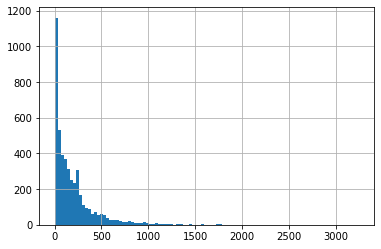

In [99]:
locations['count'].hist(bins=100)

In [100]:
locations.query('count < 10')

,location,count
4167,POINT(-77.05 38.909),9
4168,POINT(-77.094 38.947),9
4169,POINT(-77.048 38.89),9
4170,POINT(-77.012 38.873),9
4171,POINT(-77.012 38.907),9
...,...,...
4642,POINT(-77.003 38.91),1
4643,POINT(-76.952 38.876),1
4644,POINT(-77.052 38.885),1
4645,POINT(-76.985 38.888),1


In [103]:
locations.query('count < 5')

,location,count
4389,POINT(-77.008 38.952),4
4390,POINT(-77.064 38.912),4
4391,POINT(-77.078 38.932),4
4392,POINT(-76.951 38.886),4
4393,POINT(-76.979 38.885),4
...,...,...
4642,POINT(-77.003 38.91),1
4643,POINT(-76.952 38.876),1
4644,POINT(-77.052 38.885),1
4645,POINT(-76.985 38.888),1


<AxesSubplot:>

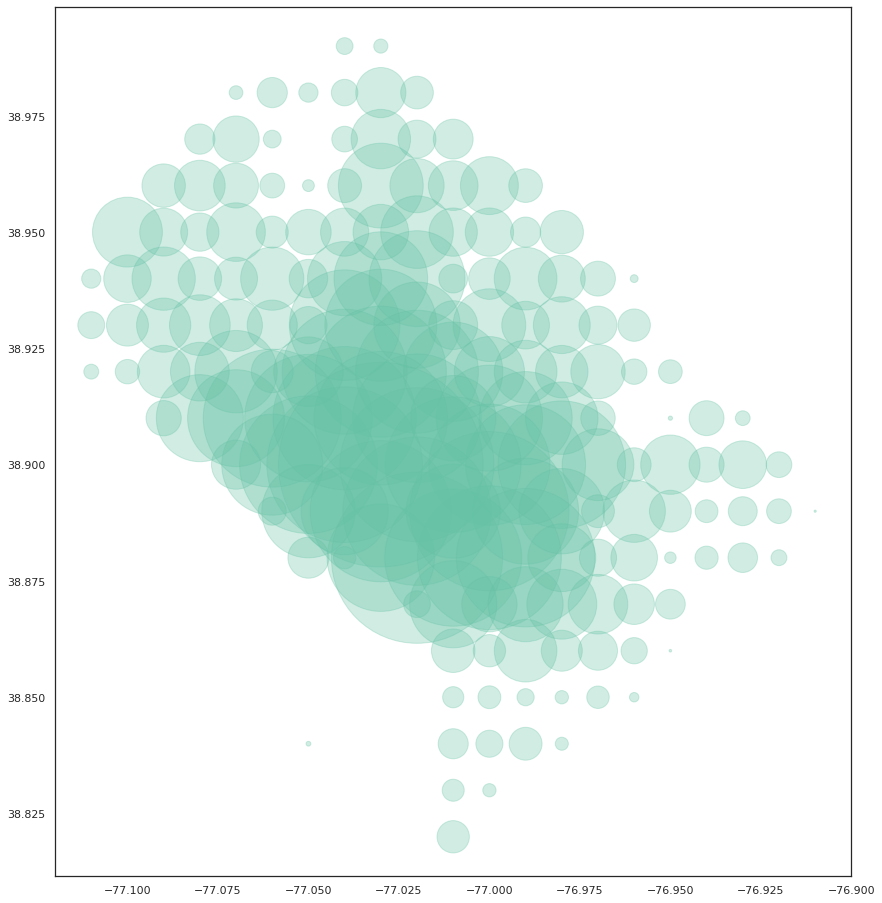

In [240]:
locations_2dp = lime_vehicles_df['rounded_coords_2dp'].value_counts().rename_axis(
    'coords').reset_index(name='count')

geometry_2dp = gpd.GeoSeries.from_wkt(locations_2dp['coords'])

rounded_2dp_gdf = gpd.GeoDataFrame(locations_2dp, geometry=geometry_2dp, crs='epsg:4326')

rounded_2dp_gdf.plot(figsize=(16, 16), markersize=rounded_2dp_gdf['count'], alpha=0.3)

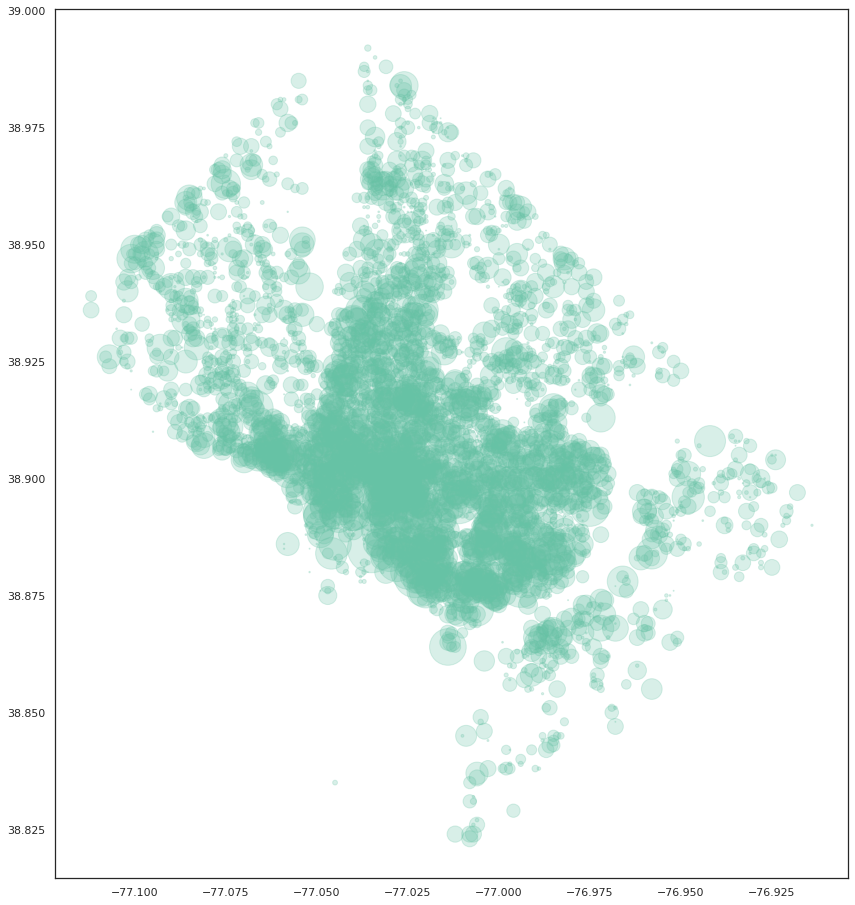

In [242]:
locations_3dp = lime_vehicles_df['rounded_coords_3dp'].value_counts().rename_axis(
    'coords').reset_index(name='count')

geometry_3dp = gpd.GeoSeries.from_wkt(locations_3dp['coords'])

rounded_3dp_gdf = gpd.GeoDataFrame(locations_3dp, geometry=geometry_3dp, crs='epsg:4326')

rounded_3dp_gdf.plot(figsize=(16, 16), markersize=rounded_3dp_gdf['count'], alpha=0.25)

<AxesSubplot:>

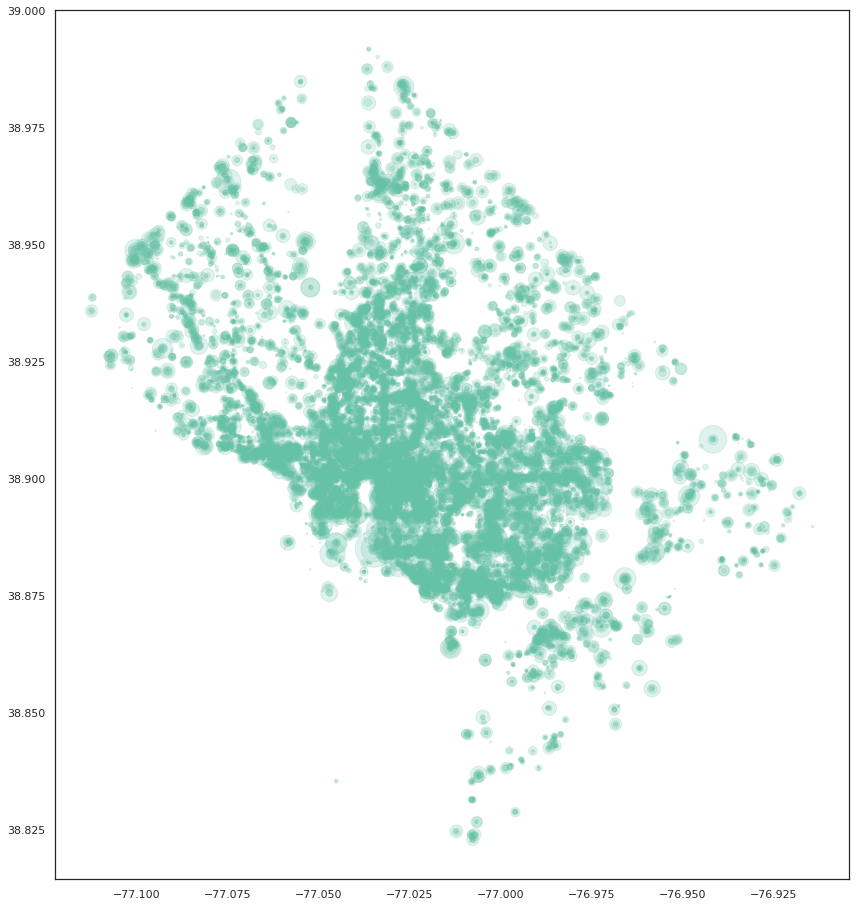

In [232]:
locations_4dp = lime_vehicles_df['rounded_coords_4dp'].value_counts().rename_axis(
    'coords').reset_index(name='count')

geometry_4dp = gpd.GeoSeries.from_wkt(locations_4dp['coords'])

rounded_4dp_gdf = gpd.GeoDataFrame(locations_4dp, geometry=geometry_4dp, crs='epsg:4326')

rounded_4dp_gdf.plot(figsize=(16, 16), markersize=rounded_4dp_gdf['count'], alpha=0.2)

In [208]:
rounded_2dp_gdf

,coords,count,geometry
0,POINT(-77.03 38.9),41892,POINT (-77.03000 38.90000)
1,POINT(-77.02 38.88),29323,POINT (-77.02000 38.88000)
2,POINT(-77 38.89),25377,POINT (-77.00000 38.89000)
3,POINT(-77.04 38.9),24211,POINT (-77.04000 38.90000)
4,POINT(-77.02 38.9),23731,POINT (-77.02000 38.90000)
...,...,...,...
174,POINT(-76.96 38.94),62,POINT (-76.96000 38.94000)
175,POINT(-77.05 38.84),23,POINT (-77.05000 38.84000)
176,POINT(-76.95 38.91),18,POINT (-76.95000 38.91000)
177,POINT(-76.95 38.86),7,POINT (-76.95000 38.86000)


### build minimal survival model

In [244]:
lime_vehicles_df

,provider,bike_id,vehicle_type,time_appeared,hour_appeared,dow_appeared,time_disappeared,duration,rounded_coords_4dp,rounded_coords_3dp,rounded_coords_2dp,geometry,duration_minutes,right_censored
0,Lime,0d09a371-e42c-4f9f-8846-da847a0a7bce,scooter,2022-04-20 00:17:00,0,Wednesday,2022-04-20 21:33:00,0 days 21:16:00,POINT(-76.9904 38.9561),POINT(-76.99 38.956),POINT(-76.99 38.96),POINT (-77.03000 38.90000),1276,False
1,Lime,d046cfdf-1181-4509-8f28-5ec277137a21,bike,2022-04-19 20:32:00,20,Tuesday,2022-04-20 07:50:00,0 days 11:18:00,POINT(-77.0013 38.9647),POINT(-77.001 38.965),POINT(-77 38.96),POINT (-77.02000 38.88000),678,False
2,Lime,196a84bd-ffe3-4fb3-8336-db10555dc9fe,bike,2022-04-18 07:46:00,7,Monday,2022-04-18 13:30:00,0 days 05:44:00,POINT(-77.0013 38.9647),POINT(-77.001 38.965),POINT(-77 38.96),POINT (-77.00000 38.89000),344,False
3,Lime,f70786a3-1955-44d1-a369-1e933fe63e95,scooter,2022-04-20 14:04:00,14,Wednesday,2022-04-20 18:34:00,0 days 04:30:00,POINT(-76.9971 38.9614),POINT(-76.997 38.961),POINT(-77 38.96),POINT (-77.04000 38.90000),270,False
4,Lime,5799ff12-5afe-4e6a-8576-6c9772edeb43,bike,2022-04-20 09:34:00,9,Wednesday,2022-04-20 14:03:00,0 days 04:29:00,POINT(-77.0013 38.9647),POINT(-77.001 38.965),POINT(-77 38.96),POINT (-77.02000 38.90000),269,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902678,Lime,ed195fb6-1381-425e-80ec-dec7faaf0ec0,scooter,2022-04-20 12:01:00,12,Wednesday,2022-04-20 12:02:00,0 days 00:01:00,POINT(-77.0229 38.8947),POINT(-77.023 38.895),POINT(-77.02 38.89),None,1,False
902679,Lime,e3c21b6f-4d83-4e49-9f38-037e927ee300,scooter,2022-04-20 16:15:00,16,Wednesday,2022-04-20 16:16:00,0 days 00:01:00,POINT(-77.0396 38.9029),POINT(-77.04 38.903),POINT(-77.04 38.9),None,1,False
902680,Lime,e3eabc11-eacf-4bd9-9a24-b70b465bb5ee,scooter,2022-04-19 20:01:00,20,Tuesday,2022-04-19 20:02:00,0 days 00:01:00,POINT(-77.0318 38.9157),POINT(-77.032 38.916),POINT(-77.03 38.92),None,1,False
902681,Lime,ec4ad3b3-61de-4866-80f7-303778f0cec1,scooter,2022-04-19 21:50:00,21,Tuesday,2022-04-19 21:51:00,0 days 00:01:00,POINT(-77.076 38.9086),POINT(-77.076 38.909),POINT(-77.08 38.91),None,1,False


In [330]:
X_cols = ['vehicle_type',
          'hour_appeared',
          'dow_appeared',
          'rounded_coords_2dp']

X = lime_vehicles_df[X_cols]

# X = lime_vehicles_df[X_cols].values
# X = X[:, np.newaxis]

In [331]:
# extract status (outcome observed=True, outcome censored=False) as separate lists
status = lime_vehicles_df['not_censored'].values
minutes = lime_vehicles_df['duration_minutes'].values

# create empty structured array
y = np.zeros(len(status), dtype={'names': ('status', 'minutes'),
                                 'formats': ('bool', 'f4')})
# add list values to structured array
y['status'] = status
y['minutes'] = minutes

Text(0.5, 0, 'time $t$')

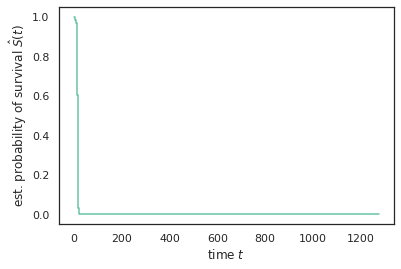

In [332]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(y['status'], y['minutes'])
plt.step(time, survival_prob, where='post')
plt.ylabel('est. probability of survival $\hat{S}(t)$')
plt.xlabel('time $t$')

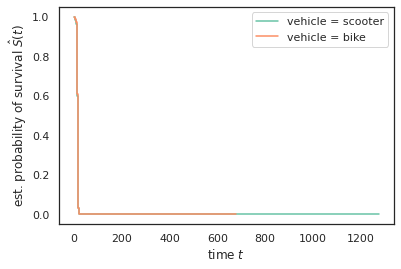

In [333]:
for vehicle_type in('scooter', 'bike'):
    mask = X['vehicle_type'] == vehicle_type
    time, survival_prob = kaplan_meier_estimator(
        y['status'][mask],
        y['minutes'][mask])
    
    plt.step(time, survival_prob, where='post', label='vehicle = %s' % vehicle_type)
    
plt.ylabel('est. probability of survival $\hat{S}(t)$')
plt.xlabel('time $t$')
plt.legend(loc='best')

In [342]:
categorical_cols = ['vehicle_type',
                    'hour_appeared',
                    'dow_appeared',
                    'rounded_coords_2dp']

for col in categorical_cols:
    X[col] = X[col].astype('category')

/tmp/ipykernel_407031/1997051322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


In [337]:
X.dtypes

vehicle_type          category
hour_appeared         category
dow_appeared          category
rounded_coords_2dp    category
dtype: object

In [343]:
from sksurv.preprocessing import OneHotEncoder

X_numeric = OneHotEncoder().fit_transform(X)

In [356]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

In [359]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()

estimator.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In [360]:
pd.Series(estimator.coef_, index=X_train.columns)

vehicle_type=scooter                      0.013739
hour_appeared=1                          -0.242893
hour_appeared=2                          -0.540659
hour_appeared=3                          -0.036383
hour_appeared=4                          -0.145354
                                            ...   
rounded_coords_2dp=POINT(-77.1 38.94)     0.904861
rounded_coords_2dp=POINT(-77.1 38.95)     0.915535
rounded_coords_2dp=POINT(-77.11 38.92)    0.888047
rounded_coords_2dp=POINT(-77.11 38.93)    0.925895
rounded_coords_2dp=POINT(-77.11 38.94)    0.895689
Length: 204, dtype: float64

In [361]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(X_test)

result = concordance_index_censored(y_test['status'], y_test['minutes'], prediction)
result[0]

0.6109414323966665

In [362]:
X['dow_appeared'].value_counts()

Wednesday    321054
Tuesday      315627
Monday       266002
Name: dow_appeared, dtype: int64

In [1]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X_train.values, y_train)
pd.Series(scores, index=X_train.columns).sort_values(ascending=False)

NameError: name 'X_train' is not defined